# Hybrid Image

Hybrid image is the sum of a low-pass filtered image and a high-pass filtered image.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(fname):
    gray_img = cv2.imread(fname, 0)    # gray image
    bgr_img = cv2.imread(fname)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return gray_img, rgb_img

In [3]:
def ideal_low_pass_filter(size_x, size_y, cutoff=0.5):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = (u**2+v**2)**(1/2)
#     print("low-pass H: {0}\n{1}".format(H.shape, H))
    for i in range(size_x):
        for j in range(size_y):
            if H[i,j]<=cutoff:
                H[i,j]=1
            else:
                H[i,j]=0
    h_min = np.min(H)
    h_max = np.max(H)
    H = (H-h_min)/(h_max-h_min)
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [4]:
def ideal_high_pass_filter(size_x, size_y, cutoff=0.5):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = (u**2+v**2)**(1/2)
#     H /= H[-1,-1]    # do the normalization
#     print("high-pass H: {0}\n{1}".format(H.shape, H))
    for i in range(size_x):
        for j in range(size_y):
            if H[i,j]<=cutoff:
                H[i,j]=0
            else:
                H[i,j]=1
    h_min = np.min(H)
    h_max = np.max(H)
    H = (H-h_min)/(h_max-h_min)
#     print("high-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [5]:
def gaussian_low_pass_filter(size_x, size_y, cutoff=10):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = np.exp(-(u**2+v**2)/(2*cutoff**2))
    h_min = np.min(H)
    h_max = np.max(H)
    H = (H-h_min)/(h_max-h_min)
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [6]:
def gaussian_high_pass_filter(size_x, size_y, cutoff=10):
    H = np.zeros((size_x, size_y))
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = 1-np.exp(-(u**2+v**2)/(2*cutoff**2))
    h_min = np.min(H)
    h_max = np.max(H)
    H = (H-h_min)/(h_max-h_min)
#     print("high-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [7]:
def get_magnitude_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum, fshift

In [8]:
def plot_img(img_1, img_2, img_3, camp=None):
    fig, ax = plt.subplots(1,3, figsize=[10, 8])
    ax[0].imshow(img_1, cmap = camp)
    ax[1].imshow(img_2, cmap = camp)
    ax[2].imshow(img_3, cmap = camp)
    plt.tight_layout()

In [9]:
def applied_filter(filter_name, x, y, c):
    if filter_name == 'low_gaussian':
        return gaussian_low_pass_filter(x, y, c)
    elif filter_name == 'high_gaussian':
        return gaussian_high_pass_filter(x, y, c)
    elif filter_name == 'low_ideal':
        return ideal_low_pass_filter(x, y, c)
    elif filter_name == 'high_ideal':
        return ideal_high_pass_filter(x, y, c)

In [10]:
def filter_image(img, cutoff, filer_name):
    magnitude_spectrum, fshift = get_magnitude_spectrum(img)
    f = applied_filter(filer_name, magnitude_spectrum.shape[0], magnitude_spectrum.shape[1], cutoff)
    out_magnitude = magnitude_spectrum * f
    output = fshift * f
    fshift  = np.fft.ifftshift(output)
    img_back = np.fft.ifft2(fshift)
    img_back = np.abs(img_back)
    return magnitude_spectrum, img_back, out_magnitude

In [11]:
def gaussian_filter_image(img, sigma, kernel):
    magnitude_spectrum, _ = get_magnitude_spectrum(img)
    img_back = cv2.GaussianBlur(img, kernel, sigma)
    out_magnitude, _ = get_magnitude_spectrum(img_back)
    return magnitude_spectrum, img_back, out_magnitude

In [64]:
def laplacian_filter_image(img, k):
    magnitude_spectrum, _ = get_magnitude_spectrum(img)
    img_back = cv2.Laplacian(img, cv2.CV_64F, ksize = k)
#     img_back = cv2.convertScaleAbs(img_back)
#     print('img_back: {0}\n{1}'.format(img_back.shape, img_back[0]))
    out_magnitude, _ = get_magnitude_spectrum(img_back)
    return magnitude_spectrum, img_back, out_magnitude

In [13]:
def normalize(img):
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

In [45]:
def hybrid_gray(file_name_1, file_name_2):
    img_1, _ = read_image(file_name_1)
    img_1 = normalize(img_1)
    magnitude_spectrum_1, img_back_1, out_magnitude_1 = filter_image(img_1, 20, 'low_gaussian')
    img_2, _ = read_image(file_name_2)
    img_2 = normalize(img_2)
    magnitude_spectrum_2, img_back_2, out_magnitude_2 = filter_image(img_2, 5, 'high_gaussian')
    
    out_magnitude_1 = normalize(out_magnitude_1)
    out_magnitude_2 = normalize(out_magnitude_2)
    
    hybrid = img_back_1 + img_back_2
    hybrid_magnitude = out_magnitude_1 + out_magnitude_2
    hybrid = normalize(hybrid)
    hybrid_magnitude = normalize(hybrid_magnitude)
    
    plot_img(out_magnitude_1, out_magnitude_2, hybrid_magnitude, 'gray')
    plot_img(img_back_1, img_back_2, hybrid, 'gray')

In [15]:
def hybrid_rgb(file_name_1, file_name_2):
    _, rgb_img_1 = read_image(file_name_1)
    r1, g1, b1 = cv2.split(rgb_img_1)
    r1 = normalize(r1)
    g1 = normalize(g1)
    b1 = normalize(b1)
    _, img_back_r1, _ = filter_image(r1, 10, 'low_gaussian')
    _, img_back_g1, _ = filter_image(g1, 10, 'low_gaussian')
    _, img_back_b1, _ = filter_image(b1, 10, 'low_gaussian')
    
    _, rgb_img_2 = read_image(file_name_2)
    r2, g2, b2 = cv2.split(rgb_img_2)
    r2 = normalize(r2)
    g2 = normalize(g2)
    b2 = normalize(b2)
    _, img_back_r2, _ = filter_image(r2, 1, 'high_gaussian')
    _, img_back_g2, _ = filter_image(g2, 1, 'high_gaussian')
    _, img_back_b2, _ = filter_image(b2, 1, 'high_gaussian')
    
    img_back_1 = cv2.merge((img_back_r1, img_back_g1, img_back_b1))
    img_back_2 = cv2.merge((img_back_r2, img_back_g2, img_back_b2))
    
    hybrid = img_back_1 + img_back_2
    hybrid[0] = normalize(hybrid[0])
    hybrid[1] = normalize(hybrid[1])
    hybrid[2] = normalize(hybrid[2])
    
    plot_img(img_back_1, img_back_2, hybrid)

In [60]:
def buildin_hybrid_gray(file_name_1, file_name_2):
    img_1, _ = read_image(file_name_1)
    magnitude_spectrum_1, img_back_1, out_magnitude_1 = gaussian_filter_image(img_1, 2, (9,9))
    img_2, _ = read_image(file_name_2)
    magnitude_spectrum_2, img_back_2, out_magnitude_2 = laplacian_filter_image(img_2, 3)
    
    hybrid = img_back_1 + img_back_2
    hybrid_magnitude = out_magnitude_1 + out_magnitude_2
    
    plot_img(out_magnitude_1, out_magnitude_2, hybrid_magnitude, 'gray')
    plot_img(img_back_1, img_back_2, hybrid, 'gray')

In [17]:
def buildin_hybrid_rgb(file_name_1, file_name_2):
    _, rgb_img_1 = read_image(file_name_1)
    r1, g1, b1 = cv2.split(rgb_img_1)
    _, img_back_r1, _ = gaussian_filter_image(r1, 2, (9,9))
    _, img_back_g1, _ = gaussian_filter_image(g1, 2, (9,9))
    _, img_back_b1, _ = gaussian_filter_image(b1, 2, (9,9))
    _, rgb_img_2 = read_image(file_name_2)
    r2, g2, b2 = cv2.split(rgb_img_2)
    _, img_back_r2, _ = laplacian_filter_image(r2, 3)
    _, img_back_g2, _ = laplacian_filter_image(g2, 3)
    _, img_back_b2, _ = laplacian_filter_image(b2, 3)
    
    img_back_r1 = img_back_r1.astype(int)
    img_back_g1 = img_back_g1.astype(int)
    img_back_b1 = img_back_b1.astype(int)
    img_back_1 = cv2.merge((img_back_r1, img_back_g1, img_back_b1))
    img_back_r2 = img_back_r2.astype(int)
    img_back_g2 = img_back_g2.astype(int)
    img_back_b2 = img_back_b2.astype(int)
    img_back_2 = cv2.merge((img_back_r2, img_back_g2, img_back_b2))
    hybrid = img_back_1 + img_back_2
    
    plot_img(img_back_1, img_back_2, hybrid, 'gray')

img_back: (361, 410)
[0.46516854 0.59550562 0.60898876 0.6        0.6        0.54606742
 0.46067416 0.4247191  0.5011236  0.63146067 0.66292135 0.59101124
 0.57303371 0.55505618 0.5505618  0.51011236 0.48764045 0.45617978
 0.37977528 0.36629213 0.32134831 0.30337079 0.37977528 0.53707865
 0.61797753 0.62247191 0.59101124 0.54606742 0.49213483 0.45168539
 0.46067416 0.46516854 0.47865169 0.57752809 0.68988764 0.76629213
 0.81573034 0.8247191  0.79775281 0.6988764  0.58651685 0.49662921
 0.43820225 0.36629213 0.36179775 0.40224719 0.35280899 0.25842697
 0.28988764 0.42022472 0.44719101 0.39775281 0.41123596 0.3752809
 0.32134831 0.26741573 0.30337079 0.38876404 0.45617978 0.48314607
 0.50561798 0.46966292 0.3752809  0.37078652 0.43370787 0.50561798
 0.53258427 0.53258427 0.54157303 0.57752809 0.60449438 0.60898876
 0.64494382 0.6        0.51011236 0.49213483 0.59550562 0.71235955
 0.75280899 0.7258427  0.67640449 0.65393258 0.64494382 0.63595506
 0.63146067 0.64044944 0.62696629 0.6     

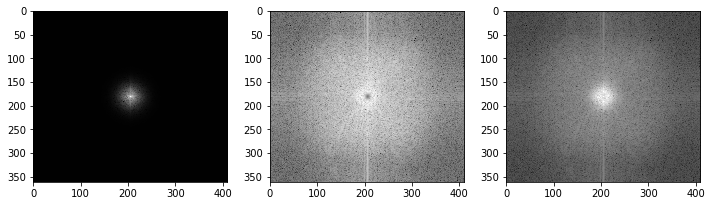

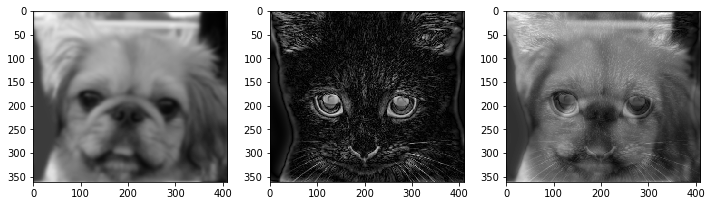

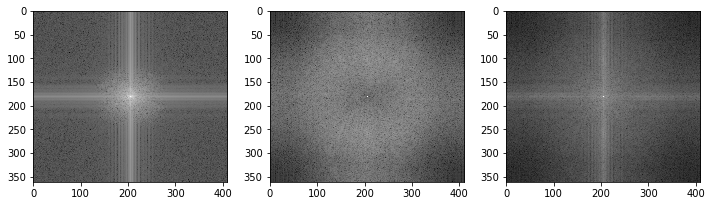

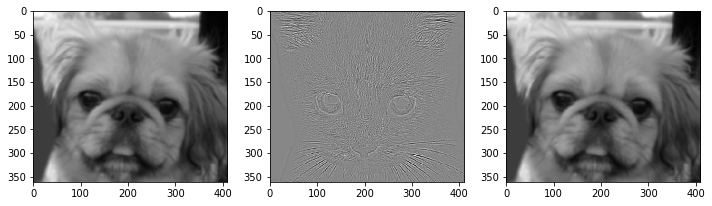

In [65]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')
# hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')
buildin_hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')
# buildin_hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/dog.bmp', './hw2_data/task1and2_hybrid_pyramid/cat.bmp')

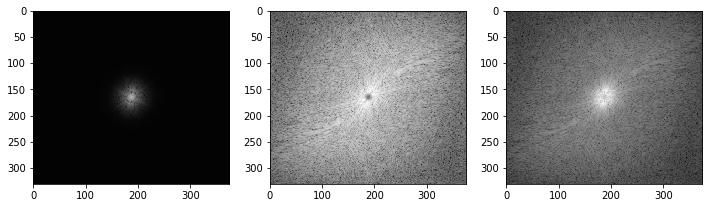

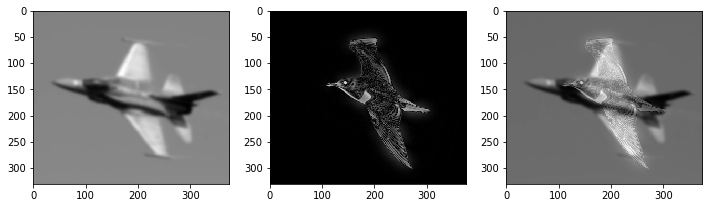

In [47]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/plane.bmp', './hw2_data/task1and2_hybrid_pyramid/bird.bmp')
# hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/plane.bmp', './hw2_data/task1and2_hybrid_pyramid/bird.bmp')

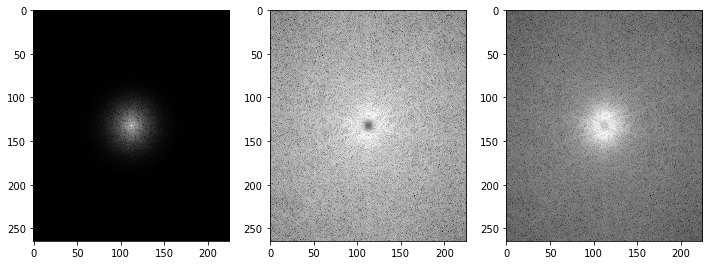

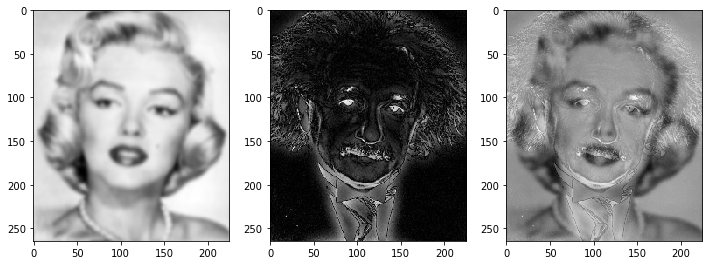

In [48]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/marilyn.bmp', './hw2_data/task1and2_hybrid_pyramid/einstein.bmp')
# hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/marilyn.bmp', './hw2_data/task1and2_hybrid_pyramid/einstein.bmp')

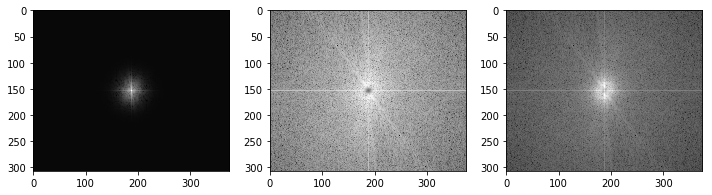

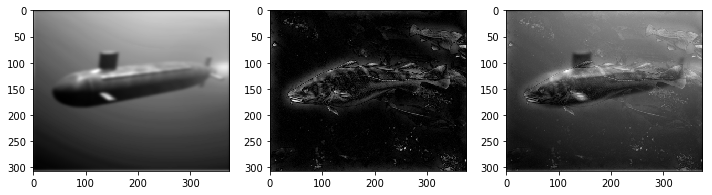

In [49]:
hybrid_gray('./hw2_data/task1and2_hybrid_pyramid/submarine.bmp', './hw2_data/task1and2_hybrid_pyramid/fish.bmp')
# hybrid_rgb('./hw2_data/task1and2_hybrid_pyramid/submarine.bmp', './hw2_data/task1and2_hybrid_pyramid/fish.bmp')